
🌡️ Temperature Prediction RMSE: 0.94 °C
🌧️ Precipitation Probability RMSE: 0.017
🌤️ Weather Condition Accuracy: 87.08%
              precision    recall  f1-score   support

       clear       0.95      0.90      0.92       639
       rainy       0.55      0.71      0.62       112

    accuracy                           0.87       751
   macro avg       0.75      0.80      0.77       751
weighted avg       0.89      0.87      0.88       751



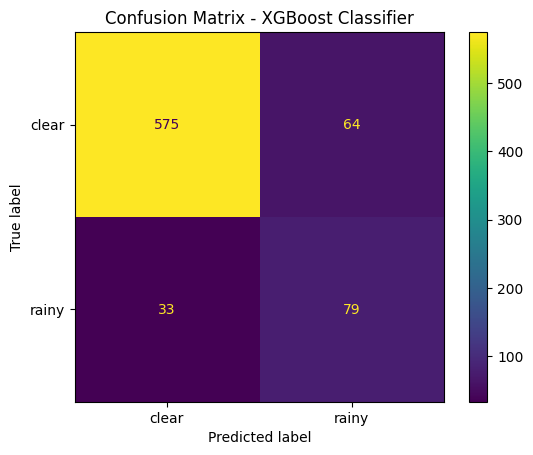


📁 CSV exported: pune_weather_forecast_with_predictions.csv


In [4]:

# Imports
from meteostat import Point, Daily, Hourly
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, XGBClassifier
import warnings

warnings.filterwarnings("ignore")

# Fetch weather data
location = Point(18.5204, 73.8567)  # Pune
start = datetime(2015, 1, 1)
end = datetime(2025, 4, 10)

# Daily weather
daily_data = Daily(location, start, end).fetch().reset_index()
daily_data.rename(columns={
    'time': 'date_time',
    'tavg': 'temperature',
    'prcp': 'precipitation',
    'wspd': 'wind_speed',
    'pres': 'pressure'
}, inplace=True)
daily_data = daily_data[['date_time', 'temperature', 'tmin', 'tmax', 'precipitation', 'wind_speed', 'pressure']]
daily_data.fillna(daily_data.median(numeric_only=True), inplace=True)

# Hourly humidity
hourly_data = Hourly(location, start, end).fetch().reset_index()
hourly_data['date_time'] = hourly_data['time'].dt.date
humidity = hourly_data.groupby('date_time')['rhum'].mean().reset_index()
humidity.rename(columns={'rhum': 'humidity'}, inplace=True)
humidity['date_time'] = pd.to_datetime(humidity['date_time'])

# Merge
dfdd targets
df['forecasted_temperature'] = df['temperature'].shift(-1)
max_precip = df['precipitation'].max()
df['precipitation_probability'] = df['precipitation'] / (max_precip + 0.001)
df['forecasted_precip_prob'] = df['precipitation_probability'].shift(-1)
df['weather_condition'] = np.where(df['precipitation'] > 1.0, 'rainy', 'clear')
df['forecasted_condition'] = df['weather_condition'].shift(-1)

# Time featu = pd.merge(daily_data, humidity, on='date_time', how='left')

# Ares
df['month'] = df['date_time'].dt.month
df['day_of_year'] = df['date_time'].dt.dayofyear
df['season'] = df['month'] % 12 // 3 + 1
df['is_monsoon'] = df['month'].isin([6, 7, 8, 9]).astype(int)

# Drop NaNs
df.dropna(inplace=True)




# Features and targets
features = ['temperature', 'tmin', 'tmax', 'wind_speed', 'pressure',
            'precipitation', 'humidity', 'month', 'day_of_year', 'season', 'is_monsoon']

target_temp = 'forecasted_temperature'
target_precip = 'forecasted_precip_prob'
target_cond = 'forecasted_condition'

# Label encode classification target
le = LabelEncoder()
df['forecasted_condition_encoded'] = le.fit_transform(df['forecasted_condition'])

# Feature set
X = df[features]

# Regression - temperature
y_temp = df[target_temp]
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)

# Regression - precipitation
y_precip = df[target_precip]
X_train_precip, X_test_precip, y_train_precip, y_test_precip = train_test_split(X, y_precip, test_size=0.2, random_state=42)

# Classification - condition
y_cond = df['forecasted_condition_encoded']
X_train_cond, X_test_cond, y_train_cond, y_test_cond = train_test_split(X, y_cond, test_size=0.2, random_state=42)

# Oversample classification training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_cond, y_train_cond)

# === XGBoost Models ===
reg_temp = XGBRegressor(n_estimators=100, random_state=42)
reg_precip = XGBRegressor(n_estimators=100, random_state=42)
cls_cond = XGBClassifier(n_estimators=100, random_state=42)

# Fit models
reg_temp.fit(X_train_temp, y_train_temp)
reg_precip.fit(X_train_precip, y_train_precip)
cls_cond.fit(X_resampled, y_resampled)

# Predict
df['predicted_temperature'] = reg_temp.predict(X)
df['predicted_precip_prob'] = reg_precip.predict(X)
df['predicted_condition_encoded'] = cls_cond.predict(X)
df['predicted_condition'] = le.inverse_transform(df['predicted_condition_encoded'])

# Evaluation
y_pred_temp = reg_temp.predict(X_test_temp)
y_pred_precip = reg_precip.predict(X_test_precip)
y_pred_cond = cls_cond.predict(X_test_cond)

rmse_temp = np.sqrt(mean_squared_error(y_test_temp, y_pred_temp))
rmse_precip = np.sqrt(mean_squared_error(y_test_precip, y_pred_precip))
acc_cond = accuracy_score(y_test_cond, y_pred_cond)

print(f"\n🌡️ Temperature Prediction RMSE: {rmse_temp:.2f} °C")
print(f"🌧️ Precipitation Probability RMSE: {rmse_precip:.3f}")
print(f"🌤️ Weather Condition Accuracy: {acc_cond:.2%}")
print(classification_report(y_test_cond, y_pred_cond, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_cond, y_pred_cond)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()

# Export to CSV
df.to_csv("pune_weather_forecast_with_predictions.csv", index=False)
print("\n📁 CSV exported: pune_weather_forecast_with_predictions.csv")


In [5]:
df

,date_time,temperature,tmin,tmax,precipitation,wind_speed,pressure,humidity,forecasted_temperature,precipitation_probability,...,forecasted_condition,month,day_of_year,season,is_monsoon,forecasted_condition_encoded,predicted_temperature,predicted_precip_prob,predicted_condition_encoded,predicted_condition
0,2015-01-01,18.7,20.1,24.4,0.0,6.9,1010.2,78.750000,18.9,0.0,...,clear,1,1,1,0,0,19.441677,-0.000426,0,clear
1,2015-01-02,18.9,20.1,26.0,0.0,6.9,1010.2,76.500000,18.9,0.0,...,clear,1,2,1,0,0,18.894394,-0.000108,0,clear
2,2015-01-03,18.9,20.1,26.6,0.0,6.9,1010.2,78.250000,19.5,0.0,...,clear,1,3,1,0,0,19.394760,0.000987,0,clear
3,2015-01-04,19.5,20.1,26.9,0.0,6.9,1010.2,77.250000,19.4,0.0,...,clear,1,4,1,0,0,19.545687,0.000195,0,clear
4,2015-01-05,19.4,20.1,27.1,0.0,6.9,1010.2,79.125000,20.4,0.0,...,clear,1,5,1,0,0,20.250265,-0.000527,0,clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,2025-04-05,28.5,19.8,37.2,0.0,6.5,1010.6,37.958333,29.3,0.0,...,clear,4,95,2,0,0,29.234983,0.000097,0,clear
3748,2025-04-06,29.3,18.8,39.2,0.0,7.6,1009.4,32.291667,30.3,0.0,...,clear,4,96,2,0,0,30.203447,0.000759,0,clear
3749,2025-04-07,30.3,21.8,38.5,0.0,9.9,1009.8,25.125000,31.4,0.0,...,clear,4,97,2,0,0,29.156631,-0.000475,0,clear
3750,2025-04-08,31.4,23.4,39.4,0.0,10.1,1010.1,25.958333,30.6,0.0,...,clear,4,98,2,0,0,30.493259,-0.000416,0,clear
